<IPython.core.display.Javascript object>

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objs as go

df = pd.read_csv('test_data.csv')
df

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2.0,50.0,12500.0,98.0,1
1,0.0,13.0,3250.0,28.0,1
2,1.0,16.0,4000.0,35.0,1
3,2.0,20.0,5000.0,45.0,1
4,1.0,24.0,6000.0,77.0,0
...,...,...,...,...,...
743,23.0,2.0,500.0,38.0,0
744,21.0,2.0,500.0,52.0,0
745,23.0,3.0,750.0,62.0,0
746,39.0,1.0,250.0,39.0,0


# What sorts of questions would a hospital be interested in with this dataset.

1. Recency (months) - The number of months since the most recent donation

2. Frequency (times) - Total number of blood donation of particular donor

3. Monetary (c.c. blood) - Total amount of blood that the donor has donated in C.C

4. Time (months) - Number of months since the donor's first donation

5. whether he/she donated blood in March 2007 - This is a binary variable which represents whether the donor donated blood in March 2007 (0 - not donate blood and 1 - blood donate)


### Interesting Use Cases that might be answered by the dataset
- I want to visualize what does the spread of the dataset looks like to better understand the outliers, missing values, distribution type

- I want to find a way to see which patients donated the most over a set amount of time


### Check for missing values

In [22]:
df.isnull().sum()

Recency (months)                              40
Frequency (times)                             33
Monetary (c.c. blood)                         40
Time (months)                                 33
whether he/she donated blood in March 2007     0
dtype: int64

### Visualize missing values

<AxesSubplot: >

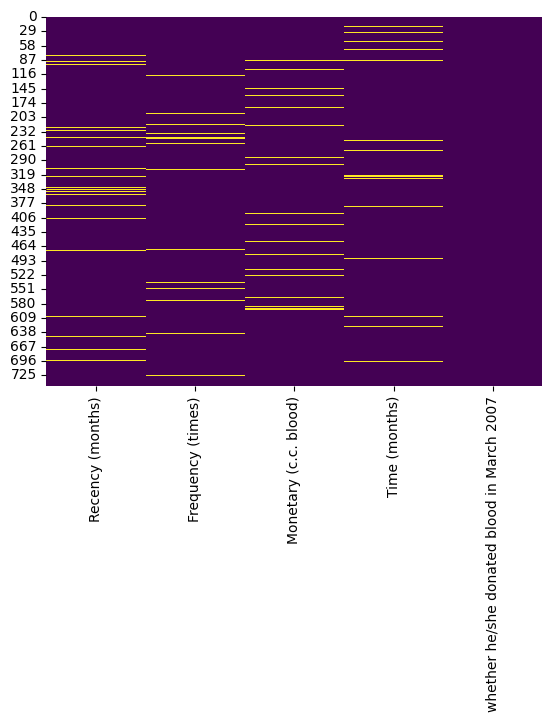

In [23]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')

### Look at entire data spread for each feature

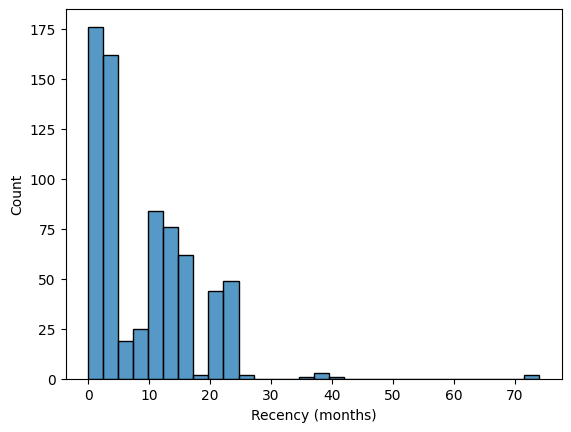

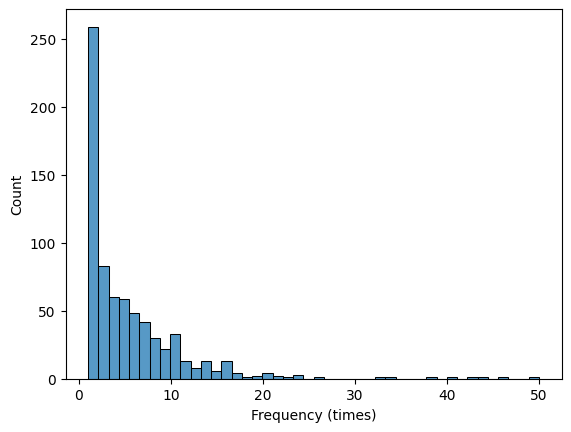

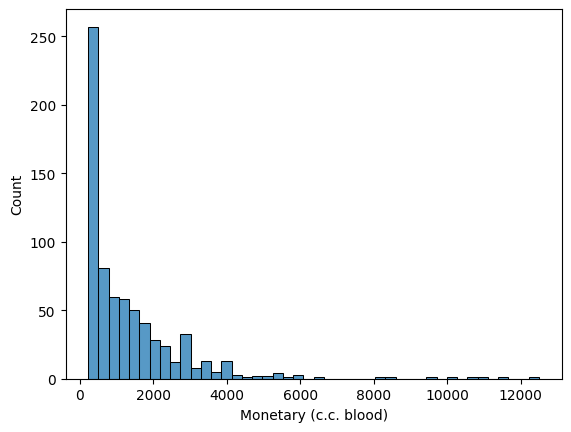

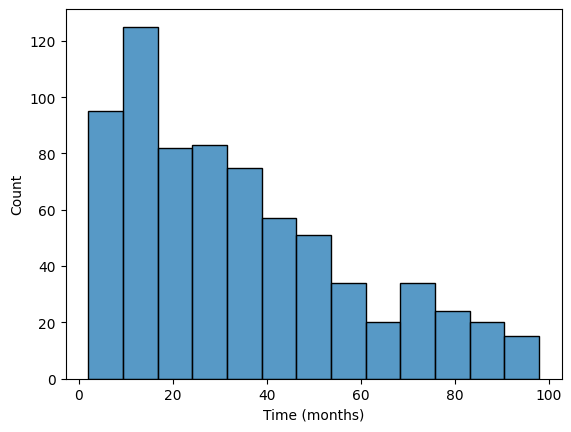

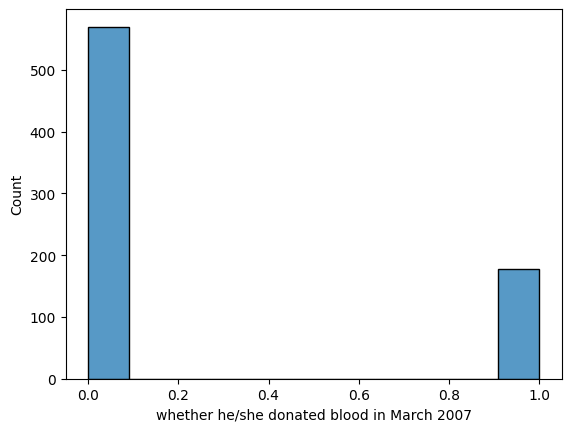

In [24]:

import warnings

warnings.filterwarnings(action='default', category=UnicodeWarning) 

for idx, col in enumerate(df.columns):
    plt.figure()
    sns.histplot(df[col])
    

### All columns are skewed which indicates we should replace missing values with median over mean

In [62]:

df.rename(columns={'whether he/she donated blood in March 2007': 'target'}, inplace=True)
y = df.target
x = df.drop(columns='target')
x.fillna(x.median(), inplace=True)

### Revisualize missing values, there should be none

<AxesSubplot: >

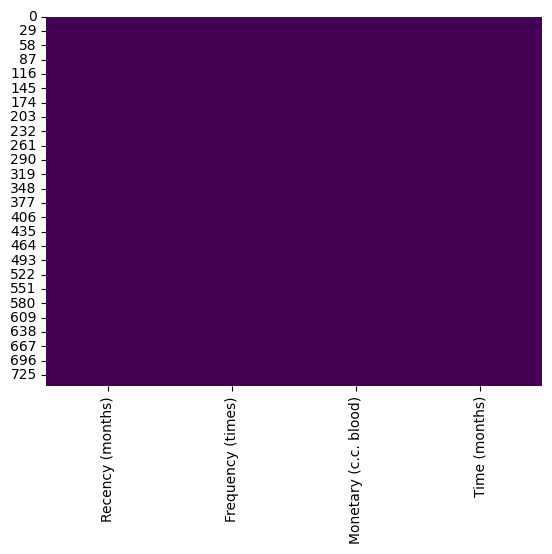

In [65]:
sns.heatmap(x.isnull(), cbar=False, cmap='viridis')


### Interactive 3D plot to explore the data a big more

In [66]:
# # Import modules
# import plotly
# import plotly.graph_objs as go

# #Make Plotly figure
# fig1 = go.Scatter3d(x=df['Recency (months)'],
#                   y=df['Frequency (times)'],
#                   z=df['Monetary (c.c. blood)'],
#                   mode='markers')

# #Make Plot.ly Layout
# mylayout = go.Layout(xaxis=dict(title="Recency (months)"),
#                      yaxis=dict(title="Frequency (times)"),)
# #Plot and save html
# plotly.offline.plot({"data": [fig1],
#                      "layout": mylayout},
#                      auto_open=True)

## Logistic Regression Model to predict Blood Donations

In [142]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.1, train_size=.9, stratify=y)


### Check data spread before and after to get a sanity check to make sure the proportions are the same

Text(0.5, 1.0, 'Proportion After "train_test_split"')

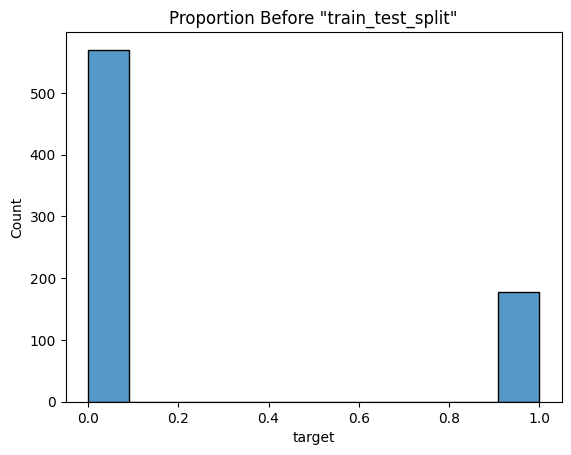

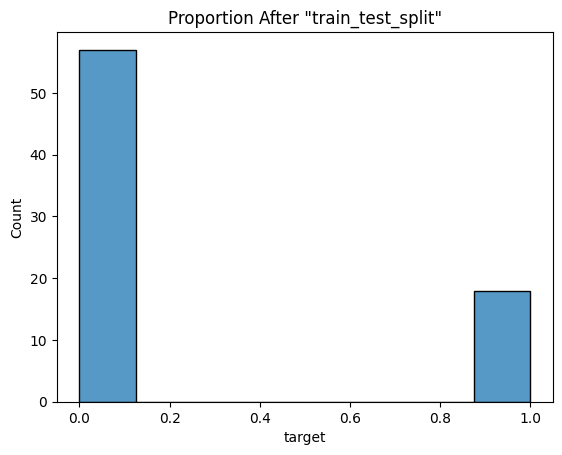

In [71]:
sns.histplot(df.iloc[:,-1])
plt.title('Proportion Before "train_test_split"')
plt.figure()
sns.histplot(y_test)
plt.title('Proportion After "train_test_split"')


### Create the model and get the best one
- use cross validation because the dataset is so small

In [141]:
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import operator



pipe = Pipeline([('dtree', DecisionTreeClassifier()),
              ('svm', SVC()),
              ('linear', LinearRegression()),
              ('xgboost', XGBClassifier())])

parameters = [
                {
                    'clf': [DecisionTreeClassifier()],
                },

                {
                    'clf': [SVC()],
                },

                {
                    'clf': [LinearRegression()],
                },

                {
                    'clf': [XGBClassifier()],
                },             
        ]
scores = []
for param in parameters:
    clf = param['clf'][0]
    steps = [('clf', clf)]
    grid = GridSearchCV(Pipeline(steps), 
                        param_grid = param,
                        cv = 5,)
    grid.fit(x_train, y_train)

    scores.append({'grid':grid, 
                   'classifier': grid.best_estimator_,
                   'best_score': grid.best_score_,
                   'best_params': grid.best_params_,
                   'cv': grid.cv})
    

result = sorted(scores, key=operator.itemgetter('best_score'),reverse=True)

#saving best classifier
print(f"best classifier: {result[0]['classifier'][0]}\nScore: {result[0]['best_score']}")
y_preds = result[0]['grid'].predict(x_test)

print(f'len of x_test: {len(x_test)}, and len of y_preds: {len(y_preds)}')
print(classification_report(y_test, y_preds, zero_division=1))


best classifier: SVC()
Score: 0.7592924267551133
len of x_test: 75, and len of y_preds: 75
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        57
           1       1.00      0.00      0.00        18

    accuracy                           0.76        75
   macro avg       0.88      0.50      0.43        75
weighted avg       0.82      0.76      0.66        75

